In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
def load_data():
    drivers = pd.read_csv('data/drivers.csv')
    results = pd.read_csv('data/results.csv')
    races = pd.read_csv('data/races.csv')
    seasons = pd.read_csv('data/seasons.csv')

    #merge the data
    results = results.merge(races[['raceId', 'year', 'round', 'circuitId' ]], on='raceId')
    results = results.merge(drivers[['driverId', 'forename', 'surname', 'nationality']], on='driverId')

    #create full name column
    results['full_name'] = results['forename'] + ' ' + results['surname']

    return results, drivers, races, seasons




In [4]:
def analyze_driver_consistency(results):
    """Analyze driver consistency across seasons"""

    #calculate points per race for each driver
    driver_points = results.groupby(['year', 'full_name'])['points'].mean().reset_index()

    #calcualate standard deviation of points to measure consistency
    driver_consistency = results.groupby('full_name')['points'].agg(['mean', 'std']).reset_index()
    driver_consistency['consistency_score'] = driver_consistency['mean'] / driver_consistency['std']

    #get top 15 most consistent drivers across minimum 50 races
    min_races = 50
    drivers_Race_count = results.groupby('full_name').size().reset_index(name='race_count')
    consistent_drivers = driver_consistency.merge(drivers_Race_count, on='full_name')
    consistent_drivers = consistent_drivers[consistent_drivers['race_count'] >= min_races]
    consistent_drivers = consistent_drivers.sort_values('consistency_score', ascending=False).head(15)
    

    return consistent_drivers
    


In [5]:
def analyze_driver_strengths(results):
    """Analyze driver strengths based on performance"""

    qualifying_performance = results.groupby('full_name').agg({
        'grid': 'mean',
        'positionOrder': 'mean'
    }).reset_index()
    
    qualifying_performance['qualifying_advantage'] = qualifying_performance['grid'] - qualifying_performance['positionOrder']
    
    # Get top 10 drivers with best race pace (relative to qualifying)
    race_pace_drivers = qualifying_performance.sort_values('qualifying_advantage', ascending=False).head(10)
    
    return race_pace_drivers



In [6]:
def create_performance_heatmap(results):
    """Create a heatmap of driver performance across different circuits"""
    # Calculate average position for each driver at each circuit
    circuit_performance = results.groupby(['circuitId', 'full_name'])['positionOrder'].mean().reset_index()
    
    # Pivot the data for heatmap
    heatmap_data = circuit_performance.pivot(index='full_name', columns='circuitId', values='positionOrder')
    
    return heatmap_data

In [7]:
def analyze_career_progression(results):
    """Analyze driver career progression"""
    # Calculate points per race over time for each driver
    career_progression = results.groupby(['year', 'full_name'])['points'].mean().reset_index()
    
    # Calculate career length for each driver
    career_length = results.groupby('full_name').agg({
        'year': ['min', 'max']
    }).reset_index()
    
    career_length.columns = ['full_name', 'start_year', 'end_year']
    career_length['career_length'] = career_length['end_year'] - career_length['start_year']
    
    return career_progression, career_length


Top 10 Most Consistent Drivers (minimum 50 races):
              full_name       mean       std  consistency_score
523      Lewis Hamilton  13.540730  9.074055           1.492247
571      Max Verstappen  13.935407  9.454186           1.473993
474         Juan Fangio   4.812759  3.583408           1.343068
132     Charles Leclerc   9.147651  7.378178           1.239825
578  Michael Schumacher   5.084416  4.183030           1.215486
765    Sebastian Vettel  10.326667  8.948382           1.154026
511        Lando Norris   7.421875  6.813152           1.089345
8           Alain Prost   3.952970  3.694694           1.069905
62         Ayrton Senna   3.790123  3.821209           0.991865
477  Juan Pablo Montoya   3.231579  3.311658           0.975819
128        Carlos Sainz   5.786058  6.034414           0.958843
385      Jackie Stewart   3.600000  3.819144           0.942620
415           Jim Clark   3.753425  4.044134           0.928116
831     Valtteri Bottas   7.238866  7.869594        

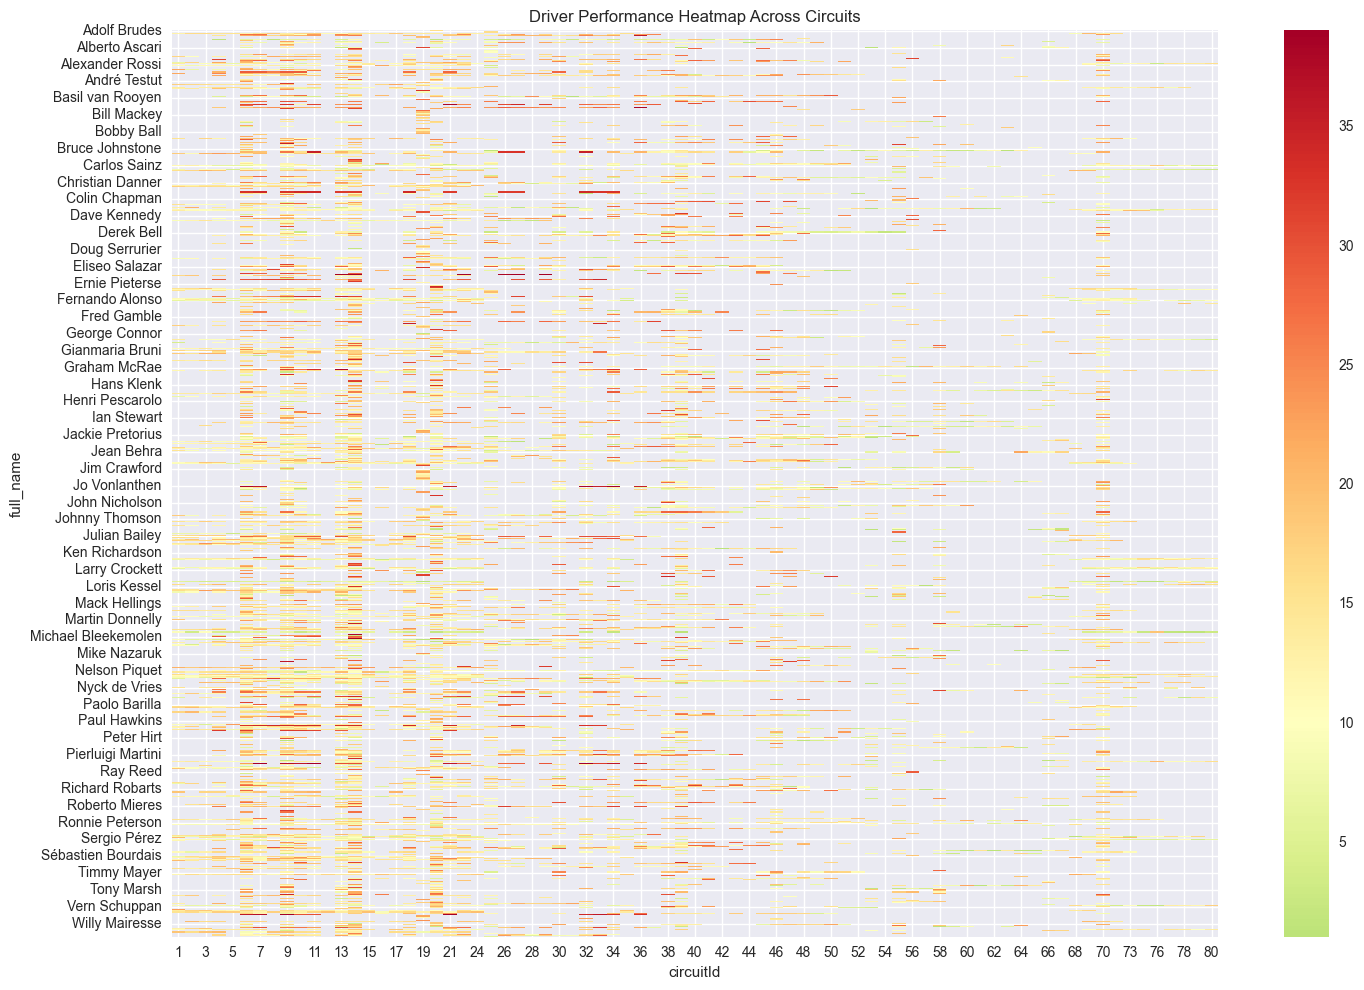

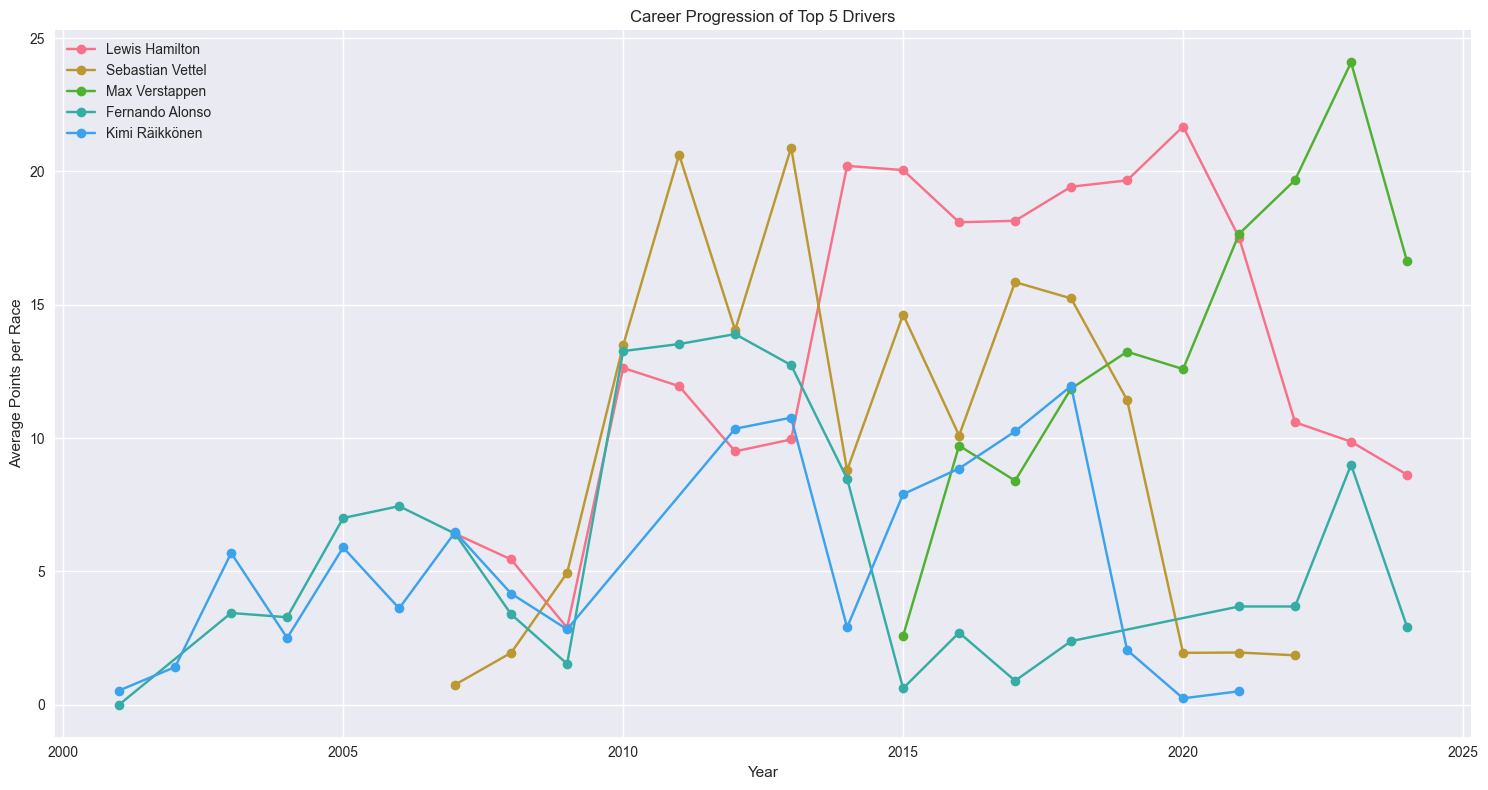

In [8]:
def main():
    # Load data
    results, drivers, races, seasons = load_data()
    
    # 1. Driver Consistency Analysis
    print("\nTop 10 Most Consistent Drivers (minimum 50 races):")
    consistent_drivers = analyze_driver_consistency(results)
    print(consistent_drivers[['full_name', 'mean', 'std', 'consistency_score']])
    
    # 2. Driver Strengths Analysis
    print("\nTop 10 Drivers with Best Race Pace (relative to qualifying):")
    race_pace_drivers = analyze_driver_strengths(results)
    print(race_pace_drivers[['full_name', 'qualifying_advantage']])
    
    # 3. Performance Heatmap
    heatmap_data = create_performance_heatmap(results)
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap='RdYlGn_r', center=10)
    plt.title('Driver Performance Heatmap Across Circuits')
    plt.tight_layout()
    plt.savefig('driver_heatmap.png')
    
    # 4. Career Progression
    career_progression, career_length = analyze_career_progression(results)
    
    # Plot career progression for top drivers
    top_drivers = results.groupby('full_name')['points'].sum().nlargest(5).index
    plt.figure(figsize=(15, 8))
    for driver in top_drivers:
        driver_data = career_progression[career_progression['full_name'] == driver]
        plt.plot(driver_data['year'], driver_data['points'], label=driver, marker='o')

    plt.title('Career Progression of Top 5 Drivers')
    plt.xlabel('Year')
    plt.ylabel('Average Points per Race')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('career_progression.png')

if __name__ == "__main__":
    main()